# **TimeGan RNN Based Simulator**

### Overview 

1. **Load Data**: Reads the consolidated sensor data from a CSV file.  
2. **Preprocess Data**: Handles missing values, normalizes data, and ensures consistent 30-second intervals.  
3. **Visualize Trends**: Plots time-series data for cooling, maxigauge, and temperature to identify patterns and anomalies.  
4. **Feature Extraction**: Computes statistical metrics (mean, std, min, max) and checks data stationarity using the ADF test.  
5. **Prepare Training Data**: Constructs time-series sequences with a chosen window size (e.g., 60 timestamps).  
6. **Build TimeGAN**: Implements an LSTM-based generator and an RNN-based discriminator to learn temporal dependencies.  
7. **Train Model**: Optimizes the TimeGAN framework using adversarial learning to generate realistic synthetic time-series data.  
8. **Evaluate Results**: Assesses the quality of generated sequences by comparing them with real sensor data using statistical and visual methods.  
9. **Generate Synthetic Data**: Uses the trained TimeGAN model to produce new sensor readings that maintain the original data's statistical properties.  
10. **Visualization**: Plots real vs. synthetic data to validate the effectiveness of the model.  
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Normalization
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Flatten, BatchNormalization, SimpleRNN
import numpy as np
import tensorflow as tf
from tqdm import tqdm

### Step 1: Prepare Training Data for TimeGAN
- Select 'cooling_channel10', 'temperature_channel1', and 'maxigauge_channel3' for training.
- Convert the dataset into sequences that TimeGAN can process.
- Define the time window (sequence length) for training.

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# 归一化到[-1, 1]范围
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# 创建训练序列
train_data = create_sequences(sensor_data_normalized, sequence_length)
# 80% 训练集，20% 测试集
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# 检查划分后的数据形状
print("\n✅ Training & Testing Data Split Completed!")
print(f"Training Data Shape: {train_data.shape}")  # 预期: (80% of total, 60, 3)
print(f"Testing Data Shape: {test_data.shape}")  # 预期: (20% of total, 60, 3)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10


✅ Training & Testing Data Split Completed!
Training Data Shape: (55193, 120, 3)
Testing Data Shape: (13799, 120, 3)

✅ Training data prepared successfully!
Training data shape: (55193, 120, 3)


In [8]:

# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# 归一化到[-1, 1]范围
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# 创建训练序列
train_data = create_sequences(sensor_data_normalized, sequence_length)
# 80% 训练集，20% 测试集
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# 检查划分后的数据形状
print("\n✅ Training & Testing Data Split Completed!")
print(f"Training Data Shape: {train_data.shape}")  # 预期: (80% of total, 60, 3)
print(f"Testing Data Shape: {test_data.shape}")  # 预期: (20% of total, 60, 3)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10


✅ Training & Testing Data Split Completed!
Training Data Shape: (55193, 120, 3)
Testing Data Shape: (13799, 120, 3)

✅ Training data prepared successfully!
Training data shape: (55193, 120, 3)


In [9]:
# Step 1: Flatten the data
train_data_reshaped = train_data.reshape(-1, 3)

# Step 2: Replace NaN and Inf (can be replaced with the mean value, default value is 0)
for i in range(train_data_reshaped.shape[1]):
    col = train_data_reshaped[:, i]
    col_mean = np.nanmean(col[np.isfinite(col)])
    col[~np.isfinite(col)] = col_mean
    train_data_reshaped[:, i] = col

# Step 3: Normalize the data to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_reshaped = scaler.fit_transform(train_data_reshaped)

# Step 4: Reshape back to the original shape
train_data = train_data_reshaped.reshape(train_data.shape)

# Step 5: Check for NaN and Inf values
for i in range(len(train_data)):
    if not np.all(np.isfinite(train_data[i])):
        print(f"⚠️ Still has NaN or Inf in batch {i}")

In [10]:
# ================== 添加监督损失组件 ==================
class TimeGAN(Model):
    def __init__(self, generator, discriminator, supervisor, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.supervisor = supervisor
        
        # 定义独立的指标跟踪器
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.sup_loss_tracker = tf.keras.metrics.Mean(name="sup_loss")

    def compile(self, gen_optimizer, disc_optimizer, sup_optimizer, 
              gen_loss_fn, disc_loss_fn, sup_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.sup_optimizer = sup_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.sup_loss_fn = sup_loss_fn

    def train_step(self, real_sequences):
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 获取判别结果
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(fake_sequences, training=True)
            
            # 计算判别器损失
            disc_loss_real = self.disc_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = self.disc_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # 更新判别器
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        # 训练生成器（含监督损失）
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape:
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 监督损失：预测下一个时间步
            pred_next_step = self.supervisor(fake_sequences[:, :-1, :])  # 使用前119步预测最后一步
            sup_loss = self.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step)
            
            # 对抗损失
            fake_output = self.discriminator(fake_sequences, training=False)
            gen_loss = self.gen_loss_fn(tf.ones_like(fake_output), fake_output)

            # 总损失组合
            total_gen_loss = gen_loss + 0.5 * sup_loss  # 权重可调

        # 更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        
        # 更新监督器
        sup_grads = sup_tape.gradient(sup_loss, self.supervisor.trainable_weights)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_weights))

        # 更新指标
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.sup_loss_tracker.update_state(sup_loss)
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "sup_loss": self.sup_loss_tracker.result(),
        }

In [11]:
# 构建监督模型
def build_supervisor():
    inputs = Input(shape=(120, 3))
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)  # 预测下一时间步
    return Model(inputs, outputs, name="Supervisor")

### Step 2: Implement TimeGAN (LSTM Generator + RNN Discriminator)
- LSTM-based Generator
- RNN-based Discriminator
- Embedding & Recovery Networks

In [14]:
#RNN
def build_generator_rnn():
    inputs = Input(shape=(120, 3))
    
    # 替换 LSTM 为 RNN（保持结构一致）
    x = SimpleRNN(24, return_sequences=True, kernel_initializer='orthogonal')(inputs)
    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='tanh')(x)
    
    outputs = Dense(3, activation='tanh', kernel_initializer='glorot_normal')(x)
    
    return Model(inputs, outputs, name="Generator")


In [15]:
def build_discriminator():
    inputs = Input(shape=(120, 3))
    x = GRU(32, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)  # 归一化
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")


discriminator = build_discriminator()
print("\n✅ Discriminator Model Summary:")
discriminator.summary()


✅ Discriminator Model Summary:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 64 (256.00 B)

In [17]:

# ==================  异常注入函数 ==================
def inject_anomalies(synthetic_data, anomaly_ratio=0.05):
    """
    注入两种类型的异常：
    1. 突然尖峰（Spike）
    2. 持续偏移（Drift）
    """
    num_sequences, seq_len, num_features = synthetic_data.shape
    num_anomalies = int(num_sequences * anomaly_ratio)
    
    # 随机选择要注入异常的序列
    anomaly_indices = np.random.choice(num_sequences, num_anomalies, replace=False)
    
    for idx in anomaly_indices:
        # 随机选择异常类型
        if np.random.rand() > 0.5:
            # 类型1：突然尖峰（持续1-3个时间步）
            spike_length = np.random.randint(1, 4)
            spike_position = np.random.randint(0, seq_len - spike_length)
            feature_idx = np.random.randint(0, num_features)
            synthetic_data[idx, spike_position:spike_position+spike_length, feature_idx] *= 5
        else:
            # 类型2：持续偏移（持续10-30个时间步）
            drift_length = np.random.randint(10, 31)
            drift_position = np.random.randint(0, seq_len - drift_length)
            feature_idx = np.random.randint(0, num_features)
            drift_value = np.random.uniform(2.0, 4.0)  # 偏移幅度
            synthetic_data[idx, drift_position:drift_position+drift_length, feature_idx] *= drift_value
    
    return synthetic_data


In [19]:
import tensorflow as tf
# ================== 初始化所有组件 ==================
generator = build_generator_rnn()
discriminator = build_discriminator()
supervisor = build_supervisor()

# 编译TimeGAN
timegan = TimeGAN(
    generator=generator,
    discriminator=discriminator,
    supervisor=supervisor
)

# 定义损失函数和优化器
# 改用更稳定的损失函数组合
timegan.compile(
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),  # 统一为clipnorm
    sup_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=0.1),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    sup_loss_fn=tf.keras.losses.MeanAbsoluteError()  # 改用MAE更稳定
)
'''
# 将异常注入移至训练完成后（避免干扰梯度）
synthetic_data = generator.predict(seed_sequences)
synthetic_data_denorm = scaler.inverse_transform(synthetic_data.reshape(-1, 3)).reshape(synthetic_data.shape)
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm)  # 仅在最终生成数据后注入
'''
# print("\n✅ 生成数据形状:", synthetic_data_denorm.shape)  # (batch_size, 120, 3)
# print("✅ 包含异常的数据示例:")
# print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看第0个序列的50-54时间步的第0个特征

'\n# 将异常注入移至训练完成后（避免干扰梯度）\nsynthetic_data = generator.predict(seed_sequences)\nsynthetic_data_denorm = scaler.inverse_transform(synthetic_data.reshape(-1, 3)).reshape(synthetic_data.shape)\nsynthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm)  # 仅在最终生成数据后注入\n'

### Step 3: Train TimeGAN (Small Training Setup)

In [21]:
from sklearn.preprocessing import MinMaxScaler

# 将数据 reshape 成适合 MinMaxScaler 的格式
train_data_reshaped = train_data.reshape(-1, 3)  # 展平成 (所有样本 * 时间步, 3)

# 归一化到 (-1, 1) 之间
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_reshaped = scaler.fit_transform(train_data_reshaped)

# 重新 reshape 回原始形状
train_data = train_data_reshaped.reshape(train_data.shape)


In [22]:
import numpy as np

for i in range(len(train_data)):
    if np.isnan(train_data[i]).any() or np.isinf(train_data[i]).any():
        print(f"⚠️ Warning: NaN or Inf detected in batch {i}")


In [ ]:
# ================== 使用预定义的 TimeGAN 类 ==================
# 定义优化器参数（符合 TimeGAN 训练特点）
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    sup_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

# ================== 改进训练流程 ==================
epochs = 10 # 改1
batch_size = 32
sequence_length = 120  # 每个时间序列的长度

# 处理数据批次，避免打乱时间顺序
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).shuffle(buffer_size=5, reshuffle_each_iteration=True)

# 训练循环
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs}")
    progress_bar = tqdm(train_dataset, desc="Training Progress")
    
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_sup_loss = 0.0
    
    for batch in progress_bar:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = timegan.generator(batch, training=True)

            # **修正 Supervisor 输入形状**
            fake_sequences_padded = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]], mode='CONSTANT')
            
            # 监督损失（预测未来时间步）
            pred_next_step = timegan.supervisor(fake_sequences_padded, training=True)  
            sup_loss = timegan.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            # 判别器损失
            d_real = timegan.discriminator(batch, training=True)
            d_fake = timegan.discriminator(fake_sequences, training=True)

            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            # 生成器损失
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))

            # 总生成器损失（包含监督损失）
            total_gen_loss = g_loss + 0.5 * sup_loss

        # 计算梯度并更新判别器
        disc_grads = disc_tape.gradient(d_loss_total, timegan.discriminator.trainable_variables)
        timegan.disc_optimizer.apply_gradients(zip(disc_grads, timegan.discriminator.trainable_variables))

        # 计算梯度并更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, timegan.generator.trainable_variables)
        timegan.gen_optimizer.apply_gradients(zip(gen_grads, timegan.generator.trainable_variables))

        # 计算梯度并更新监督器
        sup_grads = sup_tape.gradient(sup_loss, timegan.supervisor.trainable_variables)
        timegan.sup_optimizer.apply_gradients(zip(sup_grads, timegan.supervisor.trainable_variables))

        # 记录损失
        total_gen_loss += total_gen_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()
        
        # 更新进度条
        progress_bar.set_postfix({
            "Gen Loss": f"{g_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "Disc Loss": f"{d_loss_total.numpy():.4f}"
        })
    
    # 计算平均损失
    avg_gen_loss = total_gen_loss / len(train_dataset)
    avg_sup_loss = total_sup_loss / len(train_dataset)
    avg_disc_loss = total_disc_loss / len(train_dataset)

    print(f"✅ Epoch {epoch} 结束 - Gen Loss: {avg_gen_loss:.4f} | Sup Loss: {avg_sup_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}")

print("\n🎉 训练完成！")



🚀 Epoch 1/10


Training Progress: 100%|██████████| 1724/1724 [25:24<00:00,  1.13it/s, Gen Loss=2.7158, Sup Loss=0.0282, Disc Loss=0.3973]


✅ Epoch 1 结束 - Gen Loss: 0.0032 | Sup Loss: 0.0301 | Disc Loss: 0.6053

🚀 Epoch 2/10


Training Progress: 100%|██████████| 1724/1724 [25:31<00:00,  1.13it/s, Gen Loss=5.5193, Sup Loss=0.0137, Disc Loss=0.2186]


✅ Epoch 2 结束 - Gen Loss: 0.0064 | Sup Loss: 0.0170 | Disc Loss: 0.3553

🚀 Epoch 3/10


Training Progress: 100%|██████████| 1724/1724 [25:44<00:00,  1.12it/s, Gen Loss=5.6064, Sup Loss=0.0076, Disc Loss=0.1100] 


✅ Epoch 3 结束 - Gen Loss: 0.0065 | Sup Loss: 0.0113 | Disc Loss: 0.2264

🚀 Epoch 4/10


Training Progress: 100%|██████████| 1724/1724 [25:46<00:00,  1.11it/s, Gen Loss=1.4182, Sup Loss=0.0066, Disc Loss=0.3852]


✅ Epoch 4 结束 - Gen Loss: 0.0016 | Sup Loss: 0.0088 | Disc Loss: 0.2020

🚀 Epoch 5/10


Training Progress: 100%|██████████| 1724/1724 [25:37<00:00,  1.12it/s, Gen Loss=7.1732, Sup Loss=0.0085, Disc Loss=0.1706] 


✅ Epoch 5 结束 - Gen Loss: 0.0083 | Sup Loss: 0.0132 | Disc Loss: 0.2534

🚀 Epoch 6/10


Training Progress: 100%|██████████| 1724/1724 [25:31<00:00,  1.13it/s, Gen Loss=9.1233, Sup Loss=0.0107, Disc Loss=0.0999] 


✅ Epoch 6 结束 - Gen Loss: 0.0106 | Sup Loss: 0.0128 | Disc Loss: 0.1978

🚀 Epoch 7/10


Training Progress: 100%|██████████| 1724/1724 [25:19<00:00,  1.13it/s, Gen Loss=9.4450, Sup Loss=0.0215, Disc Loss=0.1297] 


✅ Epoch 7 结束 - Gen Loss: 0.0110 | Sup Loss: 0.0182 | Disc Loss: 0.1742

🚀 Epoch 8/10


Training Progress: 100%|██████████| 1724/1724 [25:28<00:00,  1.13it/s, Gen Loss=14.1786, Sup Loss=0.0082, Disc Loss=0.0204]


✅ Epoch 8 结束 - Gen Loss: 0.0165 | Sup Loss: 0.0122 | Disc Loss: 0.1069

🚀 Epoch 9/10


Training Progress: 100%|██████████| 1724/1724 [25:30<00:00,  1.13it/s, Gen Loss=16.4259, Sup Loss=0.0056, Disc Loss=0.0229]


✅ Epoch 9 结束 - Gen Loss: 0.0191 | Sup Loss: 0.0097 | Disc Loss: 0.1030

🚀 Epoch 10/10


Training Progress: 100%|██████████| 1724/1724 [25:33<00:00,  1.12it/s, Gen Loss=12.9274, Sup Loss=0.0064, Disc Loss=0.0442]

✅ Epoch 10 结束 - Gen Loss: 0.0150 | Sup Loss: 0.0105 | Disc Loss: 0.1036

🎉 训练完成！


### step 4: Generate Sythnetic Data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# ================== 🚀 Step 1: 生成数据 ==================
# 生成数据时使用噪声，而非真实数据
batch_size = 32
sequence_length = 120  # 1小时数据
num_features = 3  # 3个传感器

# 生成噪声
noise = np.random.normal(size=(batch_size, sequence_length, num_features))
synthetic_data = generator.predict(noise)

# 逆归一化数据
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, num_features)
).reshape(synthetic_data.shape)

# 注入更平滑的异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n✅ 生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

✅ 生成数据示例（含异常）:
[0.8627273  0.93734896 0.40145457 1.0262363  0.63027436]


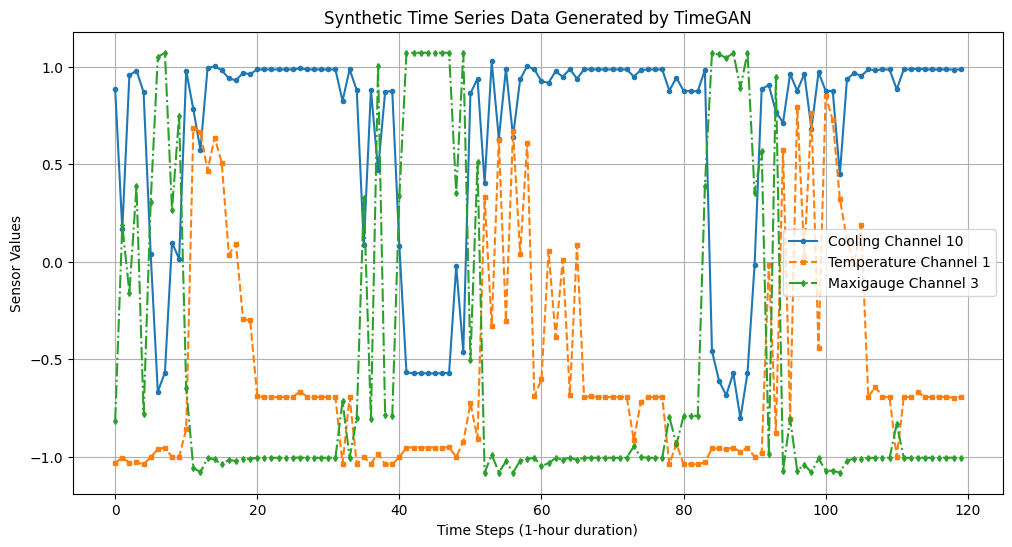


✅ 可视化图像已保存: ../databases/synthetic_time_series_rnn.png


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 2: 可视化真实 vs 生成数据 ==================
# 选择一个样本进行可视化 (batch 中的第一个)
sample_idx = 0
sample_data = synthetic_data_with_anomalies[sample_idx]  # Shape: (120, 3)
time_steps = np.arange(sequence_length)  # 时间步

# 绘制 3 个特征的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_steps, sample_data[:, 0], label="Cooling Channel 10", linestyle='-', marker='o', markersize=3)
plt.plot(time_steps, sample_data[:, 1], label="Temperature Channel 1", linestyle='--', marker='s', markersize=3)
plt.plot(time_steps, sample_data[:, 2], label="Maxigauge Channel 3", linestyle='-.', marker='d', markersize=3)

# 图像美化
plt.xlabel("Time Steps (1-hour duration)")
plt.ylabel("Sensor Values")
plt.title("Synthetic Time Series Data Generated by TimeGAN")
plt.legend()
plt.grid(True)

# 保存可视化结果
plot_filename = "../databases/synthetic_time_series_rnn.png"
plt.savefig(plot_filename)
plt.show()

print(f"\n✅ 可视化图像已保存: {plot_filename}")

In [27]:
print(synthetic_data_with_anomalies)

[[[ 0.88485545 -1.0325173  -0.8154593 ]
  [ 0.1644555  -1.0055783   0.18548241]
  [ 0.95476115 -1.0307728  -0.15875617]
  ...
  [ 0.98515844 -0.6948092  -1.0062392 ]
  [ 0.9848885  -0.6974284  -1.0058537 ]
  [ 0.9850117  -0.69623435 -1.0060302 ]]

 [[ 0.8812844  -1.0354109  -0.8071912 ]
  [ 0.12233669 -1.0046183   0.22410846]
  [ 0.9851438  -0.6947393  -1.0062267 ]
  ...
  [ 0.9852086  -0.6944577  -1.0062321 ]
  [ 0.9525891   0.17005639 -1.0143143 ]
  [ 0.98515075 -0.6945506  -1.0062462 ]]

 [[ 0.9757838  -1.0293235   0.39286107]
  [ 0.87531644 -1.0398254  -0.7930909 ]
  [ 0.8025242  -1.0352961  -0.682989  ]
  ...
  [ 0.98500854 -0.692725   -1.0062866 ]
  [ 0.9841942  -0.70382595 -1.0048685 ]
  [ 0.9850978  -0.6935846  -1.0062618 ]]

 ...

 [[ 0.8754981  -1.0397642  -0.79276055]
  [ 0.87531215 -1.039837   -0.7930287 ]
  [ 0.80490315 -1.035434   -0.686589  ]
  ...
  [ 0.9851978  -0.694594   -1.0062339 ]
  [ 0.9419033   0.00863253 -1.0160065 ]
  [ 0.9851643  -0.6947666  -1.0062424 ]]

 [

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 3: 保存生成数据到 CSV ==================
# 转换为 Pandas DataFrame
columns = ["Cooling Channel 10", "Temperature Channel 1", "Maxigauge Channel 3"]
simulated_df = pd.DataFrame(
    synthetic_data_with_anomalies.reshape(-1, num_features),
    columns=columns
)

# 保存 CSV 文件
csv_filename = "../databases/simulated_TimeGAN_rnn_output.csv"
simulated_df.to_csv(csv_filename, index=False)

print(f"\n✅ 生成数据已保存: {csv_filename}")


✅ 生成数据已保存: ../databases/simulated_TimeGAN_rnn_output.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


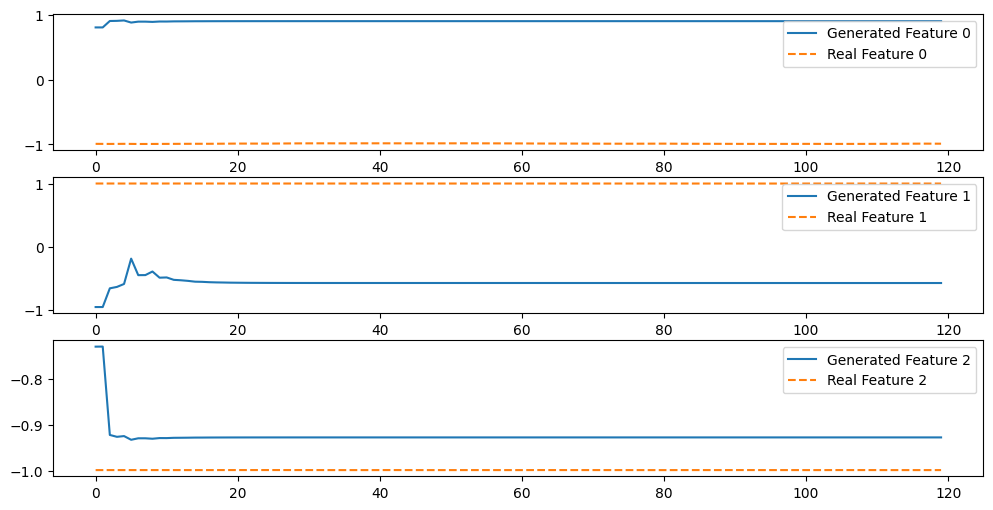

In [29]:
import matplotlib.pyplot as plt

# 生成一些新数据
num_samples = 5  # 取5个样本
seed_sequences = train_data[:num_samples]  # 用真实数据的前几个序列作为 seed
generated_data = generator.predict(seed_sequences)

# 画图
plt.figure(figsize=(12, 6))
for i in range(3):  # 遍历3个传感器通道
    plt.subplot(3, 1, i+1)
    plt.plot(generated_data[0, :, i], label=f"Generated Feature {i}")
    plt.plot(seed_sequences[0, :, i], label=f"Real Feature {i}", linestyle='dashed')
    plt.legend()
plt.show()


In [30]:
print("🚀 Checking train_data statistics:")
print(f"Min: {np.min(train_data)}, Max: {np.max(train_data)}")
print(f"Mean: {np.mean(train_data)}, Std: {np.std(train_data)}")


🚀 Checking train_data statistics:
Min: -1.0, Max: 1.0
Mean: -0.2391393895082012, Std: 0.679053864677437


In [31]:
import numpy as np

# 计算真实数据统计量
real_mean = np.mean(train_data, axis=(0,1))  # (num_features,)
real_std = np.std(train_data, axis=(0,1))

# 计算生成数据统计量
gen_mean = np.mean(generated_data, axis=(0,1))
gen_std = np.std(generated_data, axis=(0,1))

# 计算均值和标准差的相对误差
mean_diff = np.abs(real_mean - gen_mean) / real_mean
std_diff = np.abs(real_std - gen_std) / real_std

print("📊 生成数据 vs. 真实数据的误差:")
print(f"均值误差: {mean_diff}")
print(f"标准差误差: {std_diff}")


📊 生成数据 vs. 真实数据的误差:
均值误差: [ 0.65666808 -0.36281432 -1.56679454]
标准差误差: [0.95927826 0.82764703 0.90569553]


## Optimizing the hyperparameters in TimeGAN using Optuna

In [ ]:
%pip install optuna

In [ ]:
%pip install dtw-python

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

### Optimize the hyperparameters of Generator, Discriminator, and Superviso

In [42]:

def build_generator_rnn(trial):
    inputs = Input(shape=(120, 3))
    rnn_units = trial.suggest_categorical("gen_rnn_units", [16, 24, 32])
    dense_units = trial.suggest_categorical("gen_dense_units", [8, 16])
    dropout_rate = trial.suggest_float("gen_dropout", 0.1, 0.5)
    
    x = SimpleRNN(rnn_units, return_sequences=True, kernel_initializer='orthogonal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='tanh')(x)
    outputs = Dense(3, activation='tanh', kernel_initializer='glorot_normal')(x)
    
    return Model(inputs, outputs, name="Generator")

def build_discriminator(trial):
    inputs = Input(shape=(120, 3))
    gru_units = trial.suggest_categorical("disc_gru_units", [32, 64])
    dense_units = trial.suggest_categorical("disc_dense_units", [16, 32])
    dropout_rate = trial.suggest_float("disc_dropout", 0.1, 0.5)
    l2_reg = trial.suggest_float("disc_l2", 1e-5, 1e-2, log=True)
    
    x = GRU(gru_units, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")

def build_supervisor(trial):
    inputs = Input(shape=(120, 3))
    lstm1_units = trial.suggest_categorical("sup_lstm1", [32, 64])
    lstm2_units = trial.suggest_categorical("sup_lstm2", [16, 32])
    
    x = LSTM(lstm1_units, return_sequences=True)(inputs)
    x = LSTM(lstm2_units, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)
    return Model(inputs, outputs, name="Supervisor")

In [ ]:
# Define an objective function for Optuna
def objective(trial):
    generator = build_generator_rnn(trial)
    discriminator = build_discriminator(trial)
    supervisor = build_supervisor(trial)
    
    # Dummy training loop — replace with your actual training and loss evaluation
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    optimizer = Adam(learning_rate=lr)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    # Normally, you'd fit on real data — here, use dummy data just for illustration
    dummy_x = tf.random.normal((8, 120, 3))
    dummy_y = tf.random.uniform((8, 1), maxval=2, dtype=tf.int32)
    
    history = discriminator.fit(dummy_x, dummy_y, epochs=1, batch_size=4, verbose=0)
    
    return history.history["loss"][-1]

[I 2025-05-22 20:11:55,305] A new study created in memory with name: no-name-2590e89e-dae7-447b-b5c4-cd09dd3f9e49
[I 2025-05-22 20:11:55,827] Trial 0 finished with value: 0.615348219871521 and parameters: {'gen_rnn_units': 16, 'gen_dense_units': 16, 'gen_dropout': 0.18175606190624138, 'disc_gru_units': 32, 'disc_dense_units': 16, 'disc_dropout': 0.2712185745602737, 'disc_l2': 0.00046721729090793015, 'sup_lstm1': 64, 'sup_lstm2': 32, 'learning_rate': 8.722680873338973e-05}. Best is trial 0 with value: 0.615348219871521.
[I 2025-05-22 20:11:56,365] Trial 1 finished with value: 0.8479431867599487 and parameters: {'gen_rnn_units': 32, 'gen_dense_units': 16, 'gen_dropout': 0.29835235954831996, 'disc_gru_units': 32, 'disc_dense_units': 32, 'disc_dropout': 0.2958896348582816, 'disc_l2': 0.004644097213716519, 'sup_lstm1': 32, 'sup_lstm2': 32, 'learning_rate': 0.00016788935045072037}. Best is trial 0 with value: 0.615348219871521.
[I 2025-05-22 20:11:56,897] Trial 2 finished with value: 1.30262


Best trial:
gen_rnn_units: 16
gen_dense_units: 16
gen_dropout: 0.4898095069332775
disc_gru_units: 64
disc_dense_units: 16
disc_dropout: 0.2267642157070863
disc_l2: 0.0033253741041475776
sup_lstm1: 64
sup_lstm2: 16
learning_rate: 1.0252418540753458e-05


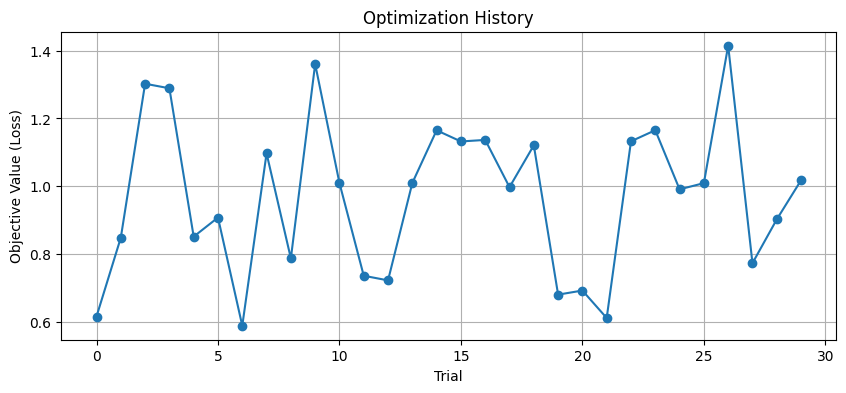

In [49]:
# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Print best parameters
print("\nBest trial:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# === Matplotlib History Plot ===
plt.figure(figsize=(10, 4))
plt.plot([t.value for t in study.trials if t.value is not None], 'o-')
plt.xlabel("Trial")
plt.ylabel("Objective Value (Loss)")
plt.title("Optimization History")
plt.grid(True)
plt.show()

### Build Generator, Discreminator and Supervior with best parameters get from Optuna

In [53]:
# === Generator ===
def build_generator():
    inputs = Input(shape=(120, 3))
    x = SimpleRNN(16, return_sequences=True, kernel_initializer='orthogonal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4233)(x)
    x = Dense(16, activation='tanh')(x)
    outputs = Dense(3, activation='tanh', kernel_initializer='glorot_normal')(x)
    return Model(inputs, outputs, name="Generator")

# === Discriminator ===
def build_discriminator():
    inputs = Input(shape=(120, 3))
    x = GRU(32, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2147)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.0005874))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")

# === Supervisor ===
def build_supervisor():
    inputs = Input(shape=(120, 3))
    x = LSTM(32, return_sequences=True)(inputs)
    x = LSTM(16, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)
    return Model(inputs, outputs, name="Supervisor")

# === Embedding & Recovery (Optional for complete TimeGAN) ===
def build_embedder():
    inputs = Input(shape=(120, 3))
    x = LSTM(32, return_sequences=True)(inputs)
    outputs = LSTM(16, return_sequences=True)(x)
    return Model(inputs, outputs, name="Embedder")

def build_recovery():
    inputs = Input(shape=(120, 16))
    x = LSTM(32, return_sequences=True)(inputs)
    outputs = LSTM(3, return_sequences=True)(x)
    return Model(inputs, outputs, name="Recovery")

# === Optimizer ===
learning_rate = 1.99e-5
optimizer = Adam(learning_rate)

# === Instantiate models ===
generator = build_generator()
discriminator = build_discriminator()
supervisor = build_supervisor()
embedder = build_embedder()
recovery = build_recovery()

# === Compile if training separately ===
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
supervisor.compile(loss='mse', optimizer=optimizer)

print("✅ Models built with best parameters from Optuna.")


✅ Models built with best parameters from Optuna.


### Train Time-Gan Model

In [54]:
# === Create folders ===
os.makedirs("saved_models_rnn", exist_ok=True)

# === Set best parameters ===
BEST_PARAMS = {
    "batch_size": 64,
    "epochs": 30,
    "learning_rate": 1.99e-5
}

# === Prepare dataset ===
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(BEST_PARAMS["batch_size"], drop_remainder=True).shuffle(100)

# === Optimizers ===
gen_optimizer = tf.keras.optimizers.Adam(BEST_PARAMS["learning_rate"])
disc_optimizer = tf.keras.optimizers.Adam(BEST_PARAMS["learning_rate"])
sup_optimizer = tf.keras.optimizers.Adam(BEST_PARAMS["learning_rate"])

# === Best model tracking ===
best_total_loss = float("inf")

# === Training loop ===
for epoch in range(1, BEST_PARAMS["epochs"] + 1):
    print(f"\nEpoch {epoch}/{BEST_PARAMS['epochs']}")
    progress_bar = tqdm(train_dataset, desc="Training")

    total_gen_loss = 0.0
    total_sup_loss = 0.0
    total_disc_loss = 0.0
    num_batches = 0

    for batch in progress_bar:
        num_batches += 1

        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            # === Generate fake sequences ===
            fake_sequences = generator(batch, training=True)

            # === Supervisor Prediction ===
            # Predict next-step using supervisor: shift fake input by 1 timestep
            padded_input = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]])
            pred_next_step = supervisor(padded_input, training=True)

            # === Supervisor loss (MSE) ===
            mse = tf.keras.losses.MeanSquaredError()
            sup_loss = mse(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])


            # === Discriminator loss ===
            d_real = discriminator(batch, training=True)
            d_fake = discriminator(fake_sequences, training=True)
            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            # === Generator loss (fooling + supervised) ===
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))
            combined_gen_loss = g_loss + 0.5 * sup_loss

        # === Apply gradients ===
        gen_grads = gen_tape.gradient(combined_gen_loss, generator.trainable_variables)
        disc_grads = disc_tape.gradient(d_loss_total, discriminator.trainable_variables)
        sup_grads = sup_tape.gradient(sup_loss, supervisor.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        sup_optimizer.apply_gradients(zip(sup_grads, supervisor.trainable_variables))

        # === Logging ===
        total_gen_loss += combined_gen_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()

        progress_bar.set_postfix({
            "G Loss": f"{combined_gen_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "D Loss": f"{d_loss_total.numpy():.4f}"
        })

    # === Epoch summary ===
    avg_g_loss = total_gen_loss / num_batches
    avg_sup_loss = total_sup_loss / num_batches
    avg_d_loss = total_disc_loss / num_batches

    print(f"Epoch {epoch} Summary - G Loss: {avg_g_loss:.4f}, Sup Loss: {avg_sup_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # === Save best models ===
    total_loss = avg_g_loss + 0.5 * avg_sup_loss
    if total_loss < best_total_loss:
        best_total_loss = total_loss
        generator.save("saved_models_rnn/best_generator.h5")
        supervisor.save("saved_models_rnn/best_supervisor.h5")
        discriminator.save("saved_models_rnn/best_discriminator.h5")
        print("✅ Best models saved!")



Epoch 1/30


Training: 100%|██████████| 862/862 [13:08<00:00,  1.09it/s, G Loss=0.9068, Sup Loss=0.0529, D Loss=0.6176]


Epoch 1 Summary - G Loss: 0.8798, Sup Loss: 0.0709, D Loss: 0.6594
✅ Best models saved!

Epoch 2/30


Training: 100%|██████████| 862/862 [12:59<00:00,  1.11it/s, G Loss=0.9219, Sup Loss=0.0385, D Loss=0.5905]


Epoch 2 Summary - G Loss: 0.9738, Sup Loss: 0.0468, D Loss: 0.5980

Epoch 3/30


Training: 100%|██████████| 862/862 [13:02<00:00,  1.10it/s, G Loss=0.8625, Sup Loss=0.0251, D Loss=0.5931]


Epoch 3 Summary - G Loss: 0.9691, Sup Loss: 0.0355, D Loss: 0.5847

Epoch 4/30


Training: 100%|██████████| 862/862 [13:03<00:00,  1.10it/s, G Loss=0.8328, Sup Loss=0.0212, D Loss=0.5988]


Epoch 4 Summary - G Loss: 0.9306, Sup Loss: 0.0289, D Loss: 0.5927

Epoch 5/30


Training: 100%|██████████| 862/862 [13:04<00:00,  1.10it/s, G Loss=0.6730, Sup Loss=0.0176, D Loss=0.6559]


Epoch 5 Summary - G Loss: 0.8829, Sup Loss: 0.0238, D Loss: 0.6112
✅ Best models saved!

Epoch 6/30


Training: 100%|██████████| 862/862 [13:04<00:00,  1.10it/s, G Loss=0.8977, Sup Loss=0.0161, D Loss=0.6393]


Epoch 6 Summary - G Loss: 0.8279, Sup Loss: 0.0201, D Loss: 0.6345
✅ Best models saved!

Epoch 7/30


Training: 100%|██████████| 862/862 [13:04<00:00,  1.10it/s, G Loss=0.6508, Sup Loss=0.0142, D Loss=0.6781]


Epoch 7 Summary - G Loss: 0.7859, Sup Loss: 0.0173, D Loss: 0.6542
✅ Best models saved!

Epoch 8/30


Training: 100%|██████████| 862/862 [12:55<00:00,  1.11it/s, G Loss=0.7560, Sup Loss=0.0123, D Loss=0.6747]


Epoch 8 Summary - G Loss: 0.7571, Sup Loss: 0.0152, D Loss: 0.6676
✅ Best models saved!

Epoch 9/30


Training: 100%|██████████| 862/862 [12:56<00:00,  1.11it/s, G Loss=1.2333, Sup Loss=0.0130, D Loss=0.7033]


Epoch 9 Summary - G Loss: 0.7404, Sup Loss: 0.0134, D Loss: 0.6766
✅ Best models saved!

Epoch 10/30


Training: 100%|██████████| 862/862 [13:00<00:00,  1.11it/s, G Loss=0.6482, Sup Loss=0.0102, D Loss=0.7054]


Epoch 10 Summary - G Loss: 0.7276, Sup Loss: 0.0120, D Loss: 0.6832
✅ Best models saved!

Epoch 11/30


Training: 100%|██████████| 862/862 [13:01<00:00,  1.10it/s, G Loss=0.6901, Sup Loss=0.0098, D Loss=0.6839]


Epoch 11 Summary - G Loss: 0.7201, Sup Loss: 0.0108, D Loss: 0.6879
✅ Best models saved!

Epoch 12/30


Training: 100%|██████████| 862/862 [13:03<00:00,  1.10it/s, G Loss=0.6632, Sup Loss=0.0087, D Loss=0.6928]


Epoch 12 Summary - G Loss: 0.7178, Sup Loss: 0.0098, D Loss: 0.6907
✅ Best models saved!

Epoch 13/30


Training: 100%|██████████| 862/862 [13:02<00:00,  1.10it/s, G Loss=0.8283, Sup Loss=0.0080, D Loss=0.7123]


Epoch 13 Summary - G Loss: 0.7160, Sup Loss: 0.0090, D Loss: 0.6927
✅ Best models saved!

Epoch 14/30


Training: 100%|██████████| 862/862 [13:02<00:00,  1.10it/s, G Loss=0.6786, Sup Loss=0.0071, D Loss=0.6960]


Epoch 14 Summary - G Loss: 0.7161, Sup Loss: 0.0084, D Loss: 0.6939
✅ Best models saved!

Epoch 15/30


Training: 100%|██████████| 862/862 [13:04<00:00,  1.10it/s, G Loss=0.7139, Sup Loss=0.0081, D Loss=0.6811]


Epoch 15 Summary - G Loss: 0.7176, Sup Loss: 0.0078, D Loss: 0.6938

Epoch 16/30


Training: 100%|██████████| 862/862 [13:03<00:00,  1.10it/s, G Loss=0.6918, Sup Loss=0.0064, D Loss=0.6948]


Epoch 16 Summary - G Loss: 0.7178, Sup Loss: 0.0074, D Loss: 0.6939

Epoch 17/30


Training: 100%|██████████| 862/862 [13:04<00:00,  1.10it/s, G Loss=0.6976, Sup Loss=0.0063, D Loss=0.6931]


Epoch 17 Summary - G Loss: 0.7171, Sup Loss: 0.0070, D Loss: 0.6933

Epoch 18/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.7021, Sup Loss=0.0057, D Loss=0.6953]


Epoch 18 Summary - G Loss: 0.7156, Sup Loss: 0.0066, D Loss: 0.6932
✅ Best models saved!

Epoch 19/30


Training: 100%|██████████| 862/862 [13:05<00:00,  1.10it/s, G Loss=0.7054, Sup Loss=0.0055, D Loss=0.6927]


Epoch 19 Summary - G Loss: 0.7160, Sup Loss: 0.0063, D Loss: 0.6919

Epoch 20/30


Training: 100%|██████████| 862/862 [13:05<00:00,  1.10it/s, G Loss=0.7043, Sup Loss=0.0056, D Loss=0.6943]


Epoch 20 Summary - G Loss: 0.7145, Sup Loss: 0.0060, D Loss: 0.6912
✅ Best models saved!

Epoch 21/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.6925, Sup Loss=0.0053, D Loss=0.6872]


Epoch 21 Summary - G Loss: 0.7094, Sup Loss: 0.0059, D Loss: 0.6907
✅ Best models saved!

Epoch 22/30


Training: 100%|██████████| 862/862 [13:07<00:00,  1.10it/s, G Loss=0.7004, Sup Loss=0.0052, D Loss=0.6901]


Epoch 22 Summary - G Loss: 0.7077, Sup Loss: 0.0057, D Loss: 0.6884
✅ Best models saved!

Epoch 23/30


Training: 100%|██████████| 862/862 [13:05<00:00,  1.10it/s, G Loss=0.7071, Sup Loss=0.0051, D Loss=0.6774]


Epoch 23 Summary - G Loss: 0.7102, Sup Loss: 0.0054, D Loss: 0.6845

Epoch 24/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.7142, Sup Loss=0.0047, D Loss=0.6864]


Epoch 24 Summary - G Loss: 0.7156, Sup Loss: 0.0052, D Loss: 0.6774

Epoch 25/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.7239, Sup Loss=0.0044, D Loss=0.6367]


Epoch 25 Summary - G Loss: 0.7232, Sup Loss: 0.0050, D Loss: 0.6598

Epoch 26/30


Training: 100%|██████████| 862/862 [13:10<00:00,  1.09it/s, G Loss=0.7561, Sup Loss=0.0048, D Loss=0.6538]


Epoch 26 Summary - G Loss: 0.7448, Sup Loss: 0.0048, D Loss: 0.6097

Epoch 27/30


Training: 100%|██████████| 862/862 [13:13<00:00,  1.09it/s, G Loss=0.7869, Sup Loss=0.0042, D Loss=0.6324]


Epoch 27 Summary - G Loss: 0.7729, Sup Loss: 0.0048, D Loss: 0.5714

Epoch 28/30


Training: 100%|██████████| 862/862 [13:08<00:00,  1.09it/s, G Loss=0.8030, Sup Loss=0.0043, D Loss=0.6579]


Epoch 28 Summary - G Loss: 0.7969, Sup Loss: 0.0048, D Loss: 0.5576

Epoch 29/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.8221, Sup Loss=0.0043, D Loss=0.6873]


Epoch 29 Summary - G Loss: 0.8196, Sup Loss: 0.0048, D Loss: 0.5475

Epoch 30/30


Training: 100%|██████████| 862/862 [13:06<00:00,  1.10it/s, G Loss=0.8346, Sup Loss=0.0042, D Loss=0.6631]

Epoch 30 Summary - G Loss: 0.8360, Sup Loss: 0.0048, D Loss: 0.5407
